In [1]:
from sentinelhub import SHConfig

import os
import datetime
import numpy as np
import matplotlib.pyplot as plt

from sentinelhub import MimeType, CRS, BBox, SentinelHubRequest, SentinelHubDownloadClient, \
    DataCollection, bbox_to_dimensions, DownloadRequest

config = SHConfig()

if not config.sh_client_id or not config.sh_client_secret:
    print("Warning! To use Process API, please provide the credentials (OAuth client ID and client secret).")


In [ ]:
# make an account and enter the relevant info
config.instance_id='your_instance_id'
config.sh_client_secret = 'your_secret_agent'
config.sh_client_id = 'your_client_id'

config.save()
config

In [25]:
# define latitude & longitude for your location
betsiboka_coords_wgs84 = [12.804867,51.334495,12.840150,51.310916]


resolution = 20
betsiboka_bbox = BBox(bbox=betsiboka_coords_wgs84, crs=CRS.WGS84)
betsiboka_size = bbox_to_dimensions(betsiboka_bbox, resolution=resolution)

print(f'Image shape at {resolution} m resolution: {betsiboka_size} pixels')

Image shape at 20 m resolution: (127, 127) pixels


In [57]:
# command for retrieving the data
# GBRI, Cloud mask
evalscript_true_color = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04", "B8A", "CLM"]
            }],
            output: {
                bands: 5
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B02, sample.B03, sample.B04, sample.B8A, sample.CLM];
    }
"""

In [58]:
def get_true_color_request(time_interval):
    return SentinelHubRequest(
        evalscript=evalscript_true_color,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L1C,
                time_interval=time_interval,
                mosaicking_order='leastCC'
            )
        ],
        responses=[
            SentinelHubRequest.output_response('default', MimeType.TIFF)
        ],
        bbox=betsiboka_bbox,
        size=betsiboka_size,
        config=config
    )

In [137]:
# For safety
# time interval & boundary
start = datetime.datetime(2020,1,28)
end = datetime.datetime(2020,11,28)
n_chunks = 61

tdelta = (end - start) / n_chunks
edges = [(start + i*tdelta).date().isoformat() for i in range(n_chunks)]
slots = [(edges[i], edges[i+1]) for i in range(len(edges)-1)]

print('Monthly time windows:\n')
for slot in slots:
    print(slot)

Monthly time windows:

('2020-01-28', '2020-02-02')
('2020-02-02', '2020-02-07')
('2020-02-07', '2020-02-12')
('2020-02-12', '2020-02-17')
('2020-02-17', '2020-02-22')
('2020-02-22', '2020-02-27')
('2020-02-27', '2020-03-03')
('2020-03-03', '2020-03-08')
('2020-03-08', '2020-03-13')
('2020-03-13', '2020-03-18')
('2020-03-18', '2020-03-23')
('2020-03-23', '2020-03-28')
('2020-03-28', '2020-04-02')
('2020-04-02', '2020-04-07')
('2020-04-07', '2020-04-12')
('2020-04-12', '2020-04-17')
('2020-04-17', '2020-04-22')
('2020-04-22', '2020-04-27')
('2020-04-27', '2020-05-02')
('2020-05-02', '2020-05-07')
('2020-05-07', '2020-05-12')
('2020-05-12', '2020-05-17')
('2020-05-17', '2020-05-22')
('2020-05-22', '2020-05-27')
('2020-05-27', '2020-06-01')
('2020-06-01', '2020-06-06')
('2020-06-06', '2020-06-11')
('2020-06-11', '2020-06-16')
('2020-06-16', '2020-06-21')
('2020-06-21', '2020-06-26')
('2020-06-26', '2020-07-01')
('2020-07-01', '2020-07-06')
('2020-07-06', '2020-07-11')
('2020-07-11', '2020

In [138]:
# create a list of requests
list_of_requests = [get_true_color_request(slot) for slot in slots]
list_of_requests = [request.download_list[0] for request in list_of_requests]

# download data with multiple threads
data = SentinelHubDownloadClient(config=config).download(list_of_requests, max_threads=5)

In [139]:
# test that it works
data[0].shape

(127, 127, 5)

In [140]:
# save as an npz file
dataNew = np.asarray(data).transpose(1,2,3,0)
data_2018 = dataNew

np.save("sentinel_data_2020", dataNew, allow_pickle=True)

In [129]:
dataNew.shape

(127, 127, 5, 60)

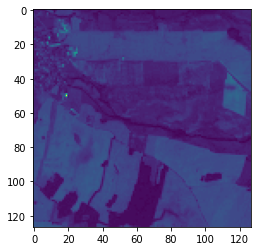

In [130]:
plt.imshow(dataNew[:,:,0,44])